In [115]:
import control as ct
from utils import Position, get_acceleration, get_position
import matplotlib.pyplot as plt
import numpy as np

In [116]:
import gym_duckietown

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

In [117]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [118]:
def my_odometry(action, x0, y0, theta0, v0=0, w0=0, dt=0.033):
    """
    Calculate the odometry from the action and the current state.

    :param action: the action to perform
    :param x0: the initial x position
    :param y0: the initial y position
    :param theta0: the initial orientation
    :param v0: the initial linear speed
    :param w0: the initial angular speed
    :param dt: the time step

    :return: (Position, float, float)
    """
    x_dot_dot, w_dot_dot = get_acceleration(action, u=v0, w=w0)

    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return Position(x1, y1, theta1), v1, w1

In [119]:
def odom(t, x, u, params):
    dt = params.get('dt', 0.033)

    v0 = u[0]
    w0 = u[1]
    # wl = u[2]
    # wr = u[3]

    x0 = x[0]
    y0 = x[1]
    theta0 = x[2]

    # x_dot_dot, w_dot_dot = get_acceleration([wl, wr], u=v0, w=w0)

    # v1 = v0 + x_dot_dot[0]*dt
    # w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return [x1, y1, theta1]

In [120]:
def my_odom_lin(v, w, x0, y0, t0, dt=0.033, v_eq=0, w_eq=0):
    u = np.array([v, w]).T

    B_00 = dt*np.cos(t0+w_eq*dt/2)
    B_01 = -v_eq*dt*np.sin(t0+w_eq*dt/2)*dt/2
    B_10 = dt*np.sin(t0+w_eq*dt/2)
    B_11 = v_eq*dt*np.cos(t0+w_eq*dt/2)*dt/2
    B_20 = 0
    B_21 = w*dt

    B = np.array([[B_00, B_01], [B_10, B_11], [B_20, B_21]])

    A0 = np.array([x0, y0, -t0]).T
    A1 = -B@np.array([v_eq, w_eq]).T

    A = A0 + A1

    x_k = A+B@u

    return x_k

In [121]:
def auto_odom_full(t, x, u, params):
    # Trick is to +1 delay
    dt = params.get('dt', 0.033)

    wl, wr = u[0], u[1]

    x0, y0, theta0, v0, w0 = x[0], x[1], x[2], x[3], x[4]

    x_dot_dot, w_dot_dot = get_acceleration([wl, wr], u=v0, w=w0)
    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v1*dt*np.cos(theta0 + w1*dt/2)
    y1 = y0 + v1*dt*np.sin(theta0 + w1*dt/2)
    theta1 = theta0 + w1*dt

    return [x1, y1, theta1, v1, w1]

In [122]:
io_odom = ct.NonlinearIOSystem(auto_odom_full, None, inputs=('wl', 'wr'), states=('x', 'y', 'th', 'v', 'w'), outputs=('x', 'y', 'th', 'v', 'w'), name='odom', params={'dt': 0.003})

In [123]:
eqpt = ct.find_eqpt(io_odom, [0]*5, [0]*2)
xeq = eqpt[0]

In [124]:
eqpt

(array([0., 0., 0., 0., 0.]), [0, 0])

In [125]:
lin_odom = ct.linearize(io_odom, xeq, 0)

In [126]:
lin_odom.A

array([[1.      , 0.      , 0.      , 0.002955, 0.      ],
       [0.      , 1.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.      , 0.002964],
       [0.      , 0.      , 0.      , 0.985   , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.988   ]])

In [127]:
lin_odom.B

array([[ 1.3500e-05,  1.3500e-05],
       [-9.1125e-16,  9.1125e-16],
       [-1.3500e-04,  1.3500e-04],
       [ 4.5000e-03,  4.5000e-03],
       [-4.5000e-02,  4.5000e-02]])

In [128]:
lin_odom.C

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [129]:
lin_odom.D

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [130]:
def linearized_odom(action, x0, y0, theta0, v0=0, w0=0, dt=0.033, return_result=False):
    io_odom = ct.NonlinearIOSystem(auto_odom_full, None, inputs=('wl', 'wr'), states=('x', 'y', 'th', 'v', 'w'), outputs=('x', 'y', 'th', 'v', 'w'), name='odom', params={'dt': dt})
    xeq, ueq = ct.find_eqpt(io_odom, [x0, y0, theta0, v0, w0], action, return_result=return_result)
    lin_odom = ct.linearize(io_odom, xeq, [0,0])
    x = lin_odom.A@[[x0], [y0], [theta0], [v0], [w0]] + lin_odom.B@[[a] for a in action]
    return x.reshape(-1)

In [131]:
action, x0, y0, theta0, v0, w0, dt = [0, 0], 0.7019999, 1.34470641, 0.0, 0, 0, 0.033
io_odom = ct.NonlinearIOSystem(auto_odom_full, None, inputs=('wl', 'wr'), states=('x', 'y', 'th', 'v', 'w'), outputs=('x', 'y', 'th', 'v', 'w'), name='odom', params={'dt': dt})
xeq, ueq = ct.find_eqpt(io_odom, [x0, y0, theta0, v0, w0], action)
lin_odom = ct.linearize(io_odom, xeq, [0,0])
x = lin_odom.A@[[x0], [y0], [theta0], [v0], [w0]] + lin_odom.B@[[a] for a in action]

In [132]:
lin_odom

sys[163]

In [133]:
linearized_odom([0, 0], 0.7019999, 1.34470641, 0.0, v0=0, w0=0, dt=0.033)

array([0.7019999 , 1.34470641, 0.        , 0.        , 0.        ])

In [134]:
auto_odom_full([0, 0], [0.7019999, 1.34470641, 0.0, 0, 0], [0, 0], {'dt': 0.033})

[0.7019999, 1.34470641, 0.0, 0.0, 0.0]

In [135]:
auto_odom_full(0, [0.7019999, 1.34470641, 0.0, 0, 0], [1, 0], {'dt': 0.033})

[0.7036333455164979, 1.3446930685370815, -0.016335000000000002, 0.0495, -0.495]

In [136]:
linearized_odom([1, 0], 0.7019999, 1.34470641, 0.0, v0=0, w0=0, dt=0.033)

array([ 0.70363324,  1.34473309, -0.016335  ,  0.0495    , -0.495     ])

In [137]:
delta_time = 1.0 / env.frame_rate

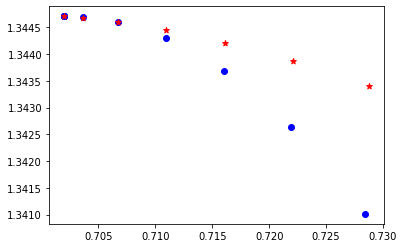

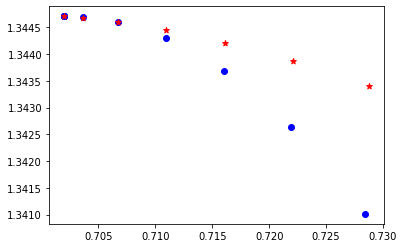

In [141]:
env.reset()
pose = get_position(env)
delay = round(0.15/delta_time)
actions = []
odoms = [pose]
poses = []
v_1 = 0
w_1 = 0
v0 = 0
w0 = 0
v = [0,0]
real_v = []
w = [0,0]
# plt.imshow(np.flip(env.render(mode="top_down"), [0]))
for i in range(10):
    action = [1,0]
    actions.append(action)
    obs, reward, done, info = env.step(action)
    if reward == -1000:
        print("Collision")
        break
    # Test odometry
    real_v.append(info["Simulator"]["robot_speed"])
    if len(actions) < delay +1:
        # p_l  = my_odom_lin(v0, w0, odoms_l[-1].x, odoms_l[-1].y, odoms_l[-1].theta, dt=delta_time, v_eq=v_1, w_eq=w_1)
        # v0, w0 = v_1, w_1
        # p, v0, w0 = auto_odom_full_direct([0,0], odoms[-1].x, odoms[-1].y, odoms[-1].theta, dt=delta_time, v0=v0, w0=w0)
        # res = auto_odom_full(0, [odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0], [0, 0], {'dt': delta_time})
        res = linearized_odom([0,0], odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time)
        p, v0, w0 = Position(*res[:3]), res[3], res[4]
    else:
        # p_l = my_odom_lin(v0, w0, odoms_l[-1].x, odoms_l[-1].y, odoms_l[-1].theta, dt=delta_time, v_eq=v_1, w_eq=w_1)
        # p, v0, w0 = auto_odom_full_direct(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, dt=delta_time, v0=v0, w0=w0)
        # res = auto_odom_full(0, [odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0], [action[0], action[1]], {'dt': delta_time})
        res = linearized_odom([action[1], action[0]], odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time, return_result=False)
        p, v0, w0 = Position(*res[:3]), res[3], res[4]
    v.append(v0)
    w.append(w0)
    odoms.append(p)
    try:
        pose = get_position(env)
    except ValueError:
        print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
        break
    poses.append(pose)
    plt.scatter(pose.x, pose.y, marker="o", c="b")
    # Test odometry
    o = get_position(env)
    plt.scatter(p.x, p.y, marker="*", c="r")
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

In [139]:
linearized_odom(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time)

array([ 0.73593928,  1.34661222, -0.36089258,  0.21627551, -2.37280347])

In [140]:
auto_odom_full(0, [odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0], action, {'dt': delta_time})

[0.7355749627256079,
 1.3437396111841202,
 -0.36089258201157015,
 0.21627550581102584,
 -2.372803467990308]